# Распределённое обучение в PyTorch

## Виды ситуаций, которые обычно возникают при распределённом обучении в PyTorch
1. Одна машина и одна GPU
2. Одна машина и много GPU (`DataParallel`)
3. Одна машина и много GPU (`DistributedDataParallel`)
4. Много машин и много GPU (`DistributedDataParallel`)
5. `torch.distribued.elastic` для совсем редких случаев (динамические ресурсы, обработка ошибок).

## Data Parallelism

<img src="https://929687.smushcdn.com/2407837/wp-content/uploads/2021/08/dp_gif.gif?size=650x265&lossy=1&strip=1&webp=1" align="centre">

In [ ]:
import torch
import torch.nn as nn


class DataParallelModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.block1 = nn.Linear(10, 20)
        self.block2 = nn.Linear(20, 20)
        # перекладываем конкретный слой на GPU с id [4, 7, 9, 12], выходной тензор кладем на GPU с id 7
        self.block2 = nn.DataParallel(
            self.block2, device_ids=[4, 7, 9, 12], output_device=[7]
        ) 

        self.block3 = nn.Linear(20, 20)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x

### Как реализован DataParallel в первом приближении

* Репликация моделей
* Распределение (scatter) данных
* Параллельное вычисление
* Собираем результат на одном устройстве

In [ ]:
def data_parallel(module, input, device_ids, output_device=None):
    # Если нет GPU, делаем вычисления на текущем устройстве
    if not device_ids:
        return module(input)
    # По умолчанию результат вычислений кладётся на первое устройство
    if output_device is None:
        output_device = device_ids[0]
    # Реплицируем модели
    replicas = nn.parallel.replicate(module, device_ids)
    # Распределяем input по нашим устройствам, получаем список тензоров
    inputs = nn.parallel.scatter(input, device_ids)
    # Оставляем ровно столько реплик, сколько у нас есть входных тензоров
    replicas = replicas[:len(inputs)]
    # Производим вычисления, получаем список результатов
    outputs = nn.parallel.parallel_apply(replicas, inputs)
    # Аггрегируем результаты на output_device
    return nn.parallel.gather(outputs, output_device)

### Одной GPU уже достаточно

In [ ]:
device = torch.device("cuda:0")

class DistributedModel(nn.Module):

    def __init__(self):
        super().__init__(
            embedding=nn.Embedding(1000, 10),  # Embedding по умолчанию лежит на CPU
            fc=nn.Linear(10, 10).to(device),   # Полносвязный слой кладём на GPU
        )

    def forward(self, x):
        x = self.embedding(x).to(device)  # Считаем Embedding на CPU, кладем на GPU
        return self.fc(x)

### Плюсы и минусы

Плюсы:
* Не надо изменять архитектуру модели
* Быстро для маленьких моделей

Минусы:
* GIL
* Слишком медленно, если модель большая
* Не применимо, если модель не помещается на какую-то из видеокарт :)
* Постоянное перекладывание модели между видеокартами

## Distributed Data-Parallel Training

* Используем процессы вмето тредов
* Один раз распределяем модель по устройствам и больше не перекладываем
* Много места для оптимизаций в подсчёте градиентов

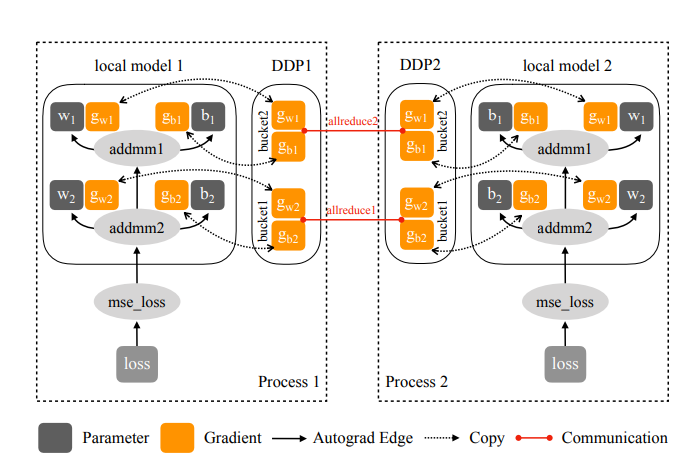

In [ ]:
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

def setup(rank, world_size):
    # Необходимо для коммуникации процессов между собой
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

# rank = порядковый номер процесса
# world_size = количество процессов = количество устройств
def example(rank, world_size):
    # Выделяем группу процессов с помощью gloo (реализация multiprocessing под капотом)
    setup(rank, world_size)
    model = nn.Linear(10, 10).to(rank)
     
    # Делаем broadcast модели по процессам 
    ddp_model = DDP(model, ids=[rank])
    
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=1e-3)

    outputs = ddp_model(torch.randn(20, 10).to(rank))
    labels = torch.randn(20, 10).to(rank)
    loss_fn(outputs, labels).backward()
    optimizer.step()

def main():
    world_size = 4
    mp.spawn(example,
        args=(world_size,),
        nprocs=world_size,
        join=True)

## Чего мы добились?

* Почти не тратим время на перекладывание модели между устройствами
* Обошли GIL

## Model Parallelism

In [ ]:
class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = torch.nn.Linear(10, 10)
        self.relu = torch.nn.ReLU()
        self.net2 = torch.nn.Linear(10, 5)

    def forward(self, x):
        x = self.relu(self.net1(x))
        return self.net2(x)

In [ ]:
class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = torch.nn.Linear(10, 10).to('cuda:0')
        self.relu = torch.nn.ReLU()
        self.net2 = torch.nn.Linear(10, 5).to('cuda:1')

    def forward(self, x):
        x = self.relu(self.net1(x.to('cuda:0')))
        return self.net2(x.to('cuda:1'))

### Можно параллелить уже имеющиеся архитектуры

In [ ]:
from torchvision.models.resnet import ResNet, Bottleneck
num_classes = 1000

In [ ]:
class ModelParallelResNet50(ResNet):
    def __init__(self, *args, **kwargs):
        # Инициализация базового ResNet50
        super(ModelParallelResNet50, self).__init__(
            Bottleneck, [3, 4, 6, 3], num_classes=num_classes, *args, **kwargs
        )
        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,
            self.layer1,
            self.layer2
        ).to('cuda:0')
        self.seq2 = nn.Sequential(
            self.layer3,
            self.layer4,
            self.avgpool,
        ).to('cuda:1')
        self.fc.to('cuda:1')

    def forward(self, x):
        x = self.seq2(self.seq1(x).to('cuda:1'))
        return self.fc(x.view(x.size(0), -1))

### Потенциальные преимущества у такой архитектуры

* Можем учить модель, которая не помещается на одно устройство
* Хотелось бы ускорить обучение в `num_devices` раз

### Попробуем написать бенчмарк

* Будем обучать модель на картинках размера 128x128, которые разобьем на 3 батча по 120 картинок 
* Запустим следующий блок кода 10 раз и замерим время первой эпохи

In [ ]:
num_batches = 3
batch_size = 120
image_w = 128
image_h = 128


def train(model):
    model.train(True)
    loss_fn = nn.MSELoss() # будем оптимизировать MSE, хоть и решаем задачу классификации :)
    optimizer = optim.SGD(model.parameters(), lr=1e-3)
    
    # Случайно сгенерируем метки классов для картинок в батче
    one_hot_indices = torch.LongTensor(batch_size).random(0, num_classes).view(batch_size, 1)

    for _ in range(num_batches):
        inputs = torch.randn(batch_size, 3, image_w, image_h)
        # Генерируем разметку
        labels = torch.zeros(batch_size, num_classes).scatter(1, one_hot_indices, 1)

        optimizer.zero_grad()
        outputs = model(inputs.to('cuda:0'))

        labels = labels.to(outputs.device)
        loss_fn(outputs, labels).backward()
        optimizer.step()

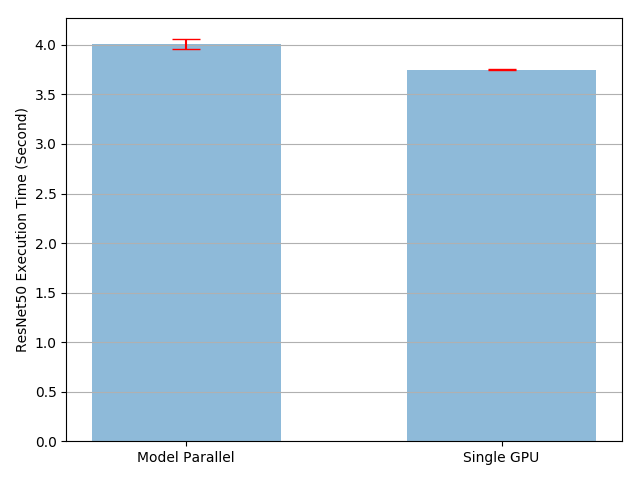

* В один момент времени работает только одна GPU
* 7% от общего времени тратится на перекладывание тензоров

## Почему все плохо?
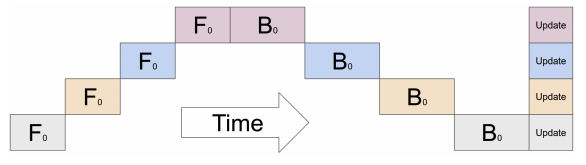

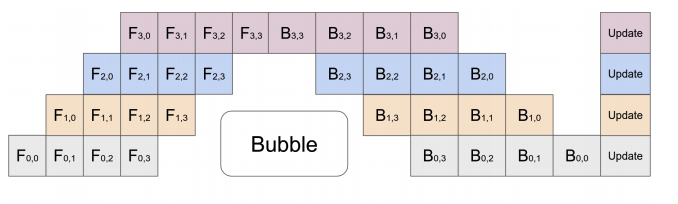

### Pipeline через примитивы PyTorch

* `torch.distributed.pipeline.sync.Pipe` пока что экспериментальный, поэтому его трогать не будем

In [ ]:
class PipelineParallelResNet50(ModelParallelResNet50):
    # добавился новый гиперпараметр split_size
    def __init__(self, split_size=20, *args, **kwargs):
        super(PipelineParallelResNet50, self).__init__(*args, **kwargs)
        self.split_size = split_size

    def forward(self, x):
        # делим batch на micro-batch
        splits = iter(x.split(self.split_size, dim=0))
        s_next = next(splits)
        s_prev = self.seq1(s_next).to('cuda:1') # forward-pass для первого слоя
        ret = []

        for s_next in splits:
            # Прогоняем результат предыдущего слоя через второй слой
            s_prev = self.seq2(s_prev)
            # Этот результат прогоняем через полносвязный слой, их результаты агрегируем
            ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

            # Прогоняем новый micro-batch через первый слой
            s_prev = self.seq1(s_next).to('cuda:1')
        
        # Собираем остатки и выводим результат
        s_prev = self.seq2(s_prev)
        ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))
        return torch.cat(ret)

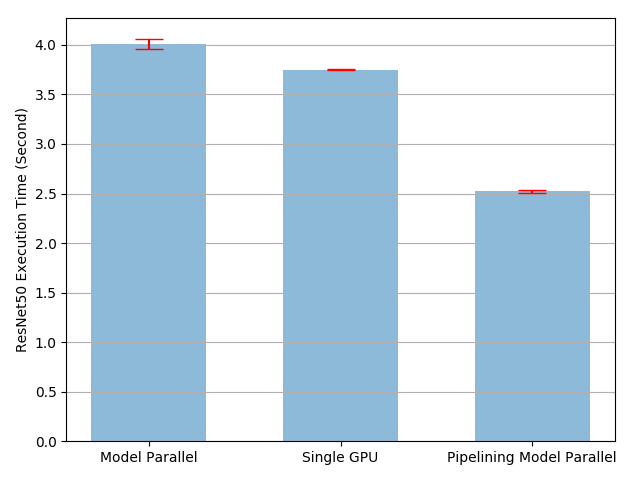

* Выиграли во времени 3.75/2.51-1=49% (относительно Single GPU)
* Неизвестно, какое влияние оказывает значение `split_size` на результат

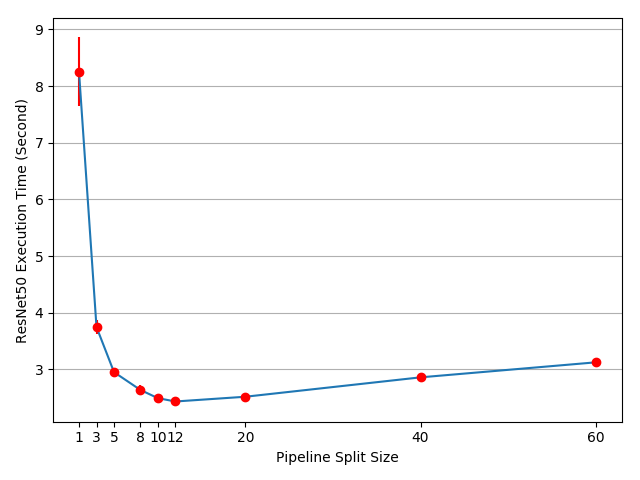

* В нашей ситуации, `split_size=12` показывает наилучший результат и даёт ~50% выигрыш во времени обучения
* Оптимальное значение зависит от окружения и архитектуры модели
* Все ещё можно быстрее, но нужно копаться в CUDA

# Итоги

* Не используем `DataParallel` из-за Global Interpreter Lock в Python
* `DistributedDataParallel` позволяет ускорить backward- и forward- проходы за счёт ускоренного прохода по данным
* Чтобы GPU не простаивали, нужно пайплайнить батч, который мы получаем на вход, через слои, лежащие на разных видеокартах